json_file = model.to_json()
with open('base-line-model.json', "w") as file:
    file.write(json_file)
#serialize weights to HDF5
model.save_weights('baseline_model_weight.h5')

In [51]:
import glob
import random as rn
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
import os

from sklearn.utils import resample
from keras.models import Sequential
from keras.layers import Dense, SeparableConv2D, Conv2D, MaxPooling2D,GlobalAveragePooling2D,MaxPool2D, Flatten, Dropout, BatchNormalization
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping # prevent overfitting
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import RMSprop, Adam
from keras.utils import to_categorical
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
from keras.callbacks import LearningRateScheduler
from sklearn.metrics import auc, roc_curve
from keras.regularizers import l2
from keras.applications.vgg19 import VGG19
from keras.applications.densenet import DenseNet121
from keras.models import Model
import tensorflow as tf
#from imblearn.over_sampling import SMOTE



%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

In [52]:
#pip install opencv-python
#pip install tensorflow
#pip install Keras
#pip install imblearn

In [53]:
# main path
path = 'data/chest_xray/'

# define paths
train_normal_dir = path + 'train/NORMAL/'
train_pneu_dir = path + 'train/PNEUMONIA/'

test_normal_dir = path + 'test/NORMAL/'
test_pneu_dir = path + 'test/PNEUMONIA/'

val_normal_dir = path + 'val/NORMAL/'
val_pneu_dir = path + 'val/PNEUMONIA/'


# find all files, our files has extension jpeg
train_normal_cases = glob.glob(train_normal_dir + '*jpeg')
train_pneu_cases = glob.glob(train_pneu_dir + '*jpeg')

test_normal_cases = glob.glob(test_normal_dir + '*jpeg')
test_pneu_cases = glob.glob(test_pneu_dir + '*jpeg')

val_normal_cases = glob.glob(val_normal_dir + '*jpeg')
val_pneu_cases = glob.glob(val_pneu_dir + '*jpeg')


# make path using / instead of \\ ... this may be redudant step
train_normal_cases = [x.replace('\\', '/') for x in train_normal_cases]
train_pneu_cases = [x.replace('\\', '/') for x in train_pneu_cases]
test_normal_cases = [x.replace('\\', '/') for x in test_normal_cases]
test_pneu_cases = [x.replace('\\', '/') for x in test_pneu_cases]
val_normal_cases = [x.replace('\\', '/') for x in val_normal_cases]
val_pneu_cases = [x.replace('\\', '/') for x in val_pneu_cases]


# create lists for train, test & validation cases, create labels as well
train_list = []
test_list = []
val_list = []

# 0 is normal and 1 is pneumonia 
for x in train_normal_cases:
    train_list.append([x, 0])
    
for x in train_pneu_cases:
    train_list.append([x, 1])
    
for x in test_normal_cases:
    test_list.append([x, 0])
    
for x in test_pneu_cases:
    test_list.append([x, 1])
    
for x in val_normal_cases:
    val_list.append([x, 0])
    
for x in val_pneu_cases:
    val_list.append([x, 1])


# shuffle/randomize data as they were loaded in order: normal cases, then pneumonia cases
rn.shuffle(train_list)
rn.shuffle(test_list)
rn.shuffle(val_list)


# create dataframes
train_df = pd.DataFrame(train_list, columns=['image', 'class'])
test_df = pd.DataFrame(test_list, columns=['image', 'class'])
val_df = pd.DataFrame(val_list, columns=['image', 'class'])

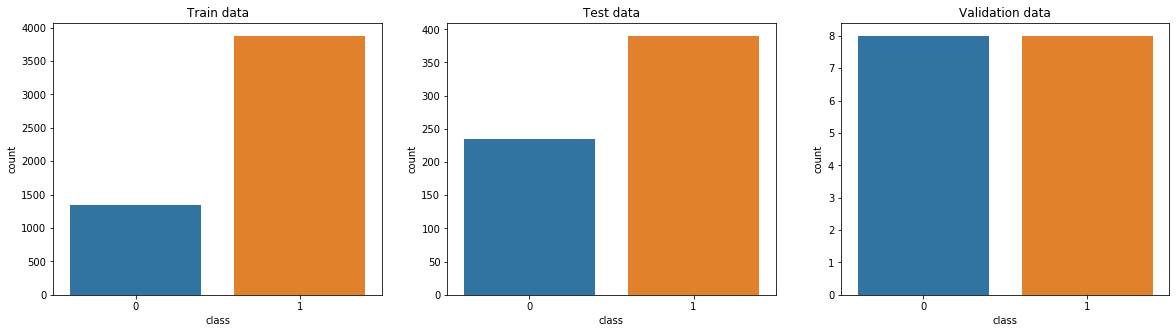

In [54]:
plt.figure(figsize=(20,5))

plt.subplot(1,3,1)
sns.countplot(train_df['class'])
plt.title('Train data')

plt.subplot(1,3,2)
sns.countplot(test_df['class'])
plt.title('Test data')

plt.subplot(1,3,3)
sns.countplot(val_df['class'])
plt.title('Validation data')

plt.show()

In [58]:
train_df[train_df['class'] == 1] + test_df[test_df['class'] == 1]

,image,class
0,data/chest_xray/train/PNEUMONIA/person281_bact...,2.0
1,NaN,NaN
2,NaN,NaN
3,data/chest_xray/train/PNEUMONIA/person498_bact...,2.0
4,data/chest_xray/train/PNEUMONIA/person480_bact...,2.0
...,...,...
5210,NaN,NaN
5211,NaN,NaN
5212,NaN,NaN
5213,NaN,NaN


* There are only 16 images in the validation set. 

# Combine validation set with test set

In [5]:
comb_df = pd.concat([train_df,val_df])
train_df_, val_df_ = train_test_split(comb_df, test_size = 0.1)

In [6]:
val_df_['class'].value_counts()

1    383
0    141
Name: class, dtype: int64

In [7]:
def balance(df):
    major = df[df['class'] == 1]
    minor = df[df['class'] == 0]
    minor_oversampled  = resample(minor,
                                 replace = True,
                                 n_samples = round(major['class'].value_counts()[1]),
                                 random_state = 42)
    combined_df = pd.concat([major, minor_oversampled])
    return combined_df

In [8]:
train_df = balance(train_df_)
val_df = balance(val_df_)
train_df = train_df.sample(frac = 1)
val_df = val_df.sample(frac = 1)



In [9]:
train_df

,image,class
4922,data/chest_xray/train/PNEUMONIA/person119_viru...,1
3322,data/chest_xray/train/NORMAL/NORMAL2-IM-0403-0...,0
3984,data/chest_xray/train/PNEUMONIA/person1605_bac...,1
2946,data/chest_xray/train/NORMAL/NORMAL2-IM-0627-0...,0
2560,data/chest_xray/train/PNEUMONIA/person62_bacte...,1
...,...,...
1798,data/chest_xray/train/NORMAL/IM-0646-0001.jpeg,0
2077,data/chest_xray/train/NORMAL/NORMAL2-IM-1336-0...,0
91,data/chest_xray/train/PNEUMONIA/person1236_bac...,1
895,data/chest_xray/train/PNEUMONIA/person290_viru...,1


--------------------------------------------------------------------------------------------------------------------

#comb_df_majority = comb_df[comb_df['class']==1]
#comb_df_minority = comb_df[comb_df['class']==0]

#comb_df_minority_oversampled = resample(comb_df_minority,
                                      replace = True,
                                      n_samples = comb_df['class'].value_counts()[1],
                                      random_state = 1)
#comb_train_df = pd.concat([comb_df_majority, comb_df_minority_oversampled])
#comb_train_df['class'].value_counts()

#combine val set and train set 
comb_df = pd.concat([train_df,val_df])

comb_df_majority = comb_df[comb_df['class']==1]
comb_df_minority = comb_df[comb_df['class']==0]

comb_df_minority_oversampled = resample(comb_df_minority,
                                      replace = True,
                                      n_samples = comb_df['class'].value_counts()[1],
                                      random_state = 1)
comb_train_df = pd.concat([comb_df_majority, comb_df_minority_oversampled])


#Split train set into new train set and val set 

train_df_ = comb_train_df.sample(frac = 0.8, random_state =1)
val_df = comb_train_df.drop(train_df_.index)

val_df['class'].value_counts()



In [10]:
#train_df, val_df = train_test_split(comb_train_df, test_size = 0.2)

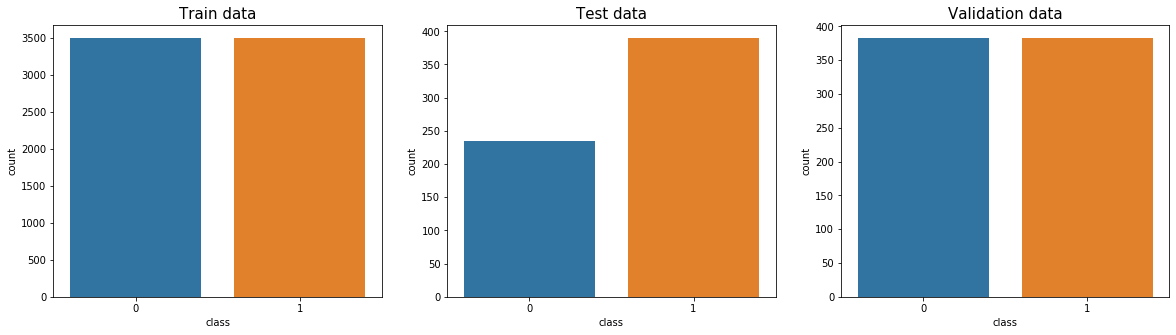

<Figure size 432x288 with 0 Axes>

In [49]:
plt.figure(figsize=(20,5))

plt.subplot(1,3,1)
sns.countplot(train_df['class'])
plt.title('Train data',fontsize=15)

plt.subplot(1,3,2)
sns.countplot(test_df['class'])
plt.title('Test data',fontsize=15)

plt.subplot(1,3,3)
sns.countplot(val_df['class'])
plt.title('Validation data',fontsize=15)

plt.show()
plt.savefig('graph/dataset-overview-.jpeg')

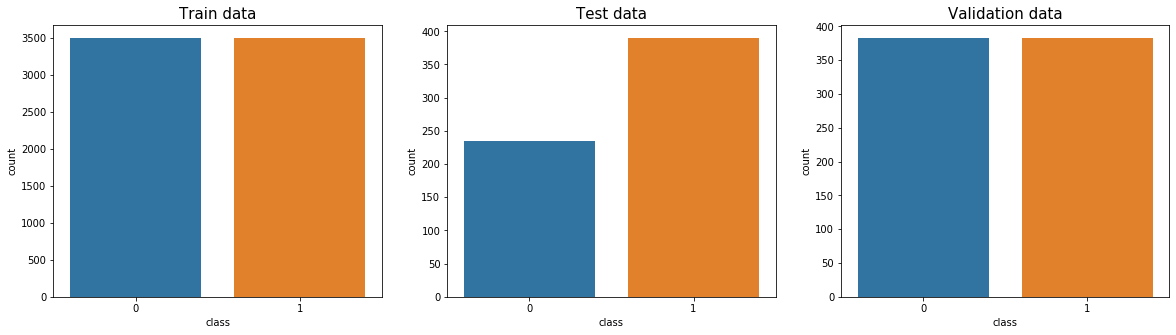

In [50]:
plt.figure(figsize=(20,5))

plt.subplot(1,3,1)
sns.countplot(train_df['class'])
plt.title('Train data',fontsize=15)

plt.subplot(1,3,2)
sns.countplot(test_df['class'])
plt.title('Test data',fontsize=15)

plt.subplot(1,3,3)
sns.countplot(val_df['class'])
plt.title('Validation data',fontsize=15)

plt.savefig('graph/dataset-overview-.jpeg')

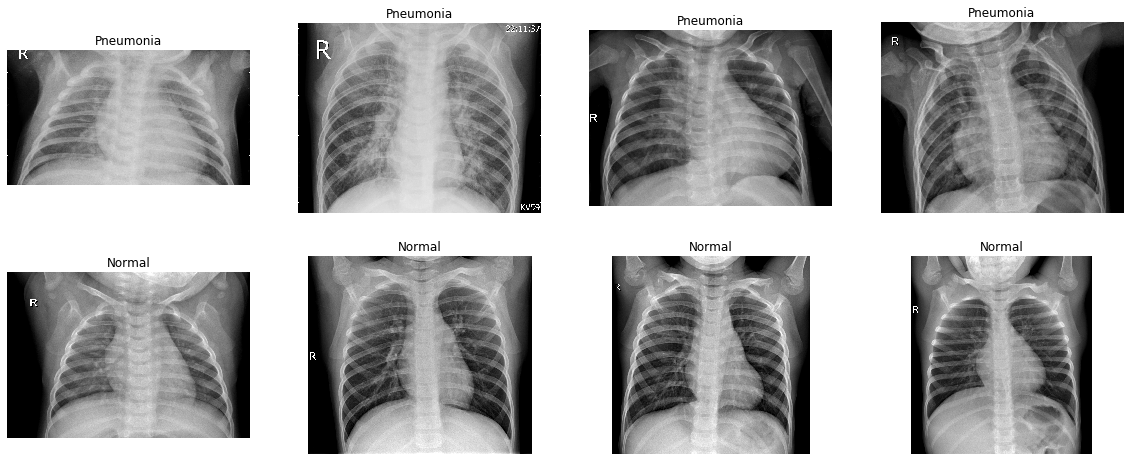

In [13]:
plt.figure(figsize=(20,8))

# plot 1st row for pneumonia xrays
for i,img_path in enumerate(train_df[train_df['class'] == 1][0:4]['image']):
    plt.subplot(2,4,i+1)
    plt.axis('off')
    img = plt.imread(img_path)
    plt.imshow(img, cmap='gray')
    plt.title('Pneumonia')

# plot 2nd row for pneumonia xrays    
for i,img_path in enumerate(train_df[train_df['class'] == 0][0:4]['image']):
    plt.subplot(2,4,4+i+1)
    plt.axis('off')
    img = plt.imread(img_path)
    plt.imshow(img, cmap='gray')
    plt.title('Normal')

In [14]:
# pre-process & normalize image
def process_data(img_path):
    img = cv2.imread(img_path)
    img = cv2.resize(img, (320, 320))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    img = img/255.0
    img = np.reshape(img, (320,320,1))
    return img

# write a function to split img and label into 2 separate numpy arrays
def compose_dataset(df):
    img = []
    labels = []

    for img_path, label in df.values:
        img.append(process_data(img_path))
        labels.append(label)
        
    return np.array(img), np.array(labels)

In [15]:
X_train, y_train = compose_dataset(train_df)
X_test, y_test = compose_dataset(test_df)
X_val, y_val = compose_dataset(val_df)

print('Train data shape: {}, Labels shape: {}'.format(X_train.shape, y_train.shape))
print('Test data shape: {}, Labels shape: {}'.format(X_test.shape, y_test.shape))
print('Validation data shape: {}, Labels shape: {}'.format(X_val.shape, y_val.shape))

Train data shape: (7000, 320, 320, 1), Labels shape: (7000,)
Test data shape: (624, 320, 320, 1), Labels shape: (624,)
Validation data shape: (766, 320, 320, 1), Labels shape: (766,)


In [16]:
## Image Augmentation

In [17]:
# define generator for traing data 
image_gen = ImageDataGenerator(
            #samplewise_center = True, #set each sample mean to 0 
            #samplewise_std_normalization = True, # divide each input by its std to normalize 
            #rescale = 1./255,
            rotation_range = 20, # randomly rotate image from -30 degree to 30 degree
            width_shift_range = 0.1, #randomly shift images horizontally
            height_shift_range = 0.1, #randomly shift images vertically
            shear_range = 0.2, #randomly change shear intensity
            zoom_range = 0.2, # random zoom images
            horizontal_flip = False, # randomly flip images
            vertical_flip = False
)

# fit generator on our train features
image_gen.fit(X_train)

In [ ]:
# convert a class vector (int) tp binary class matrix
# y_train = to_categorical(y_train)
# y_test = to_categorical(y_test)
# y_val = to_categorical(y_val)

In [ ]:
X_val.shape

In [ ]:
y_val.shape

## Fine-tuning (not done yet) 

#use callback to save a copy of the best performing model 
checkpoint = ModelCheckpoint(filepath = 'best_weights.hdf5', save_best_only = True, save_weights_only = True)

#reduce learning rate when a metric has stopped improving
#patient is the number of epochs with no improvement after learning rate is reduced
#max mode => learning rate will be reduced when the quantity monitored has stopped increasing
#lr_reduce = ReduceLROnPlateau(monitor = 'val_loss', factor = 0.2, patience = 2, verbose = 2, mode = 'max') 

#use earlystopping to prevent overfitting 
early_stop = EarlyStopping(monitor = 'val_loss', min_delta = 0.1, patience = 6, mode = 'min')

In [ ]:
# fine-tune the learning rate 
# too high learning rate will cause the model to diverge
# too low learning rate will cause the model to run slow 
def exponential_decay(lr0, s):
    def exponential_decay_fn(epoch):
        return lr0 * 0.1 **(epoch / s)
    return exponential_decay_fn

exponential_decay_fn = exponential_decay(0.001, 20)

#lr = LearningRateScheduler(exponential_decay_fn)

## Model

In [19]:
model = Sequential()

# first conv layer
model.add(Conv2D(filters = 16, kernel_size = (3,3), padding = 'same', activation = 'relu'))#, kernel_regularizer = l2( l= 0.01)))
model.add(Conv2D(filters = 16, kernel_size = (3,3), padding = 'same', activation = 'relu', kernel_regularizer = l2(l = 0.01)))
model.add(BatchNormalization()) #keep the mean outout close to 0 and output std close to 1
model.add(MaxPool2D(pool_size = (2,2)))

# second conv layer
model.add(SeparableConv2D(filters = 32, kernel_size = (3,3), padding = 'same', activation = 'relu'))#kernel_regularizer = l2(l = 0.01)))
model.add(SeparableConv2D(filters = 32, kernel_size = (3,3), padding = 'same', activation = 'relu', kernel_regularizer = l2(l = 0.001)))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size = (2,2)))
model.add(Dropout(rate = 0.1))

# third conv layer 
model.add(SeparableConv2D(filters = 64, kernel_size = (3,3), padding = 'same', activation = 'relu'))# kernel_regularizer = l2(l = 0.01)))
model.add(SeparableConv2D(filters = 64, kernel_size = (3,3), padding = 'same', activation = 'relu', kernel_regularizer = l2(l = 0.001)))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size = (2,2)))
model.add(Dropout(rate = 0.1))

# forth conv layer
model.add(SeparableConv2D(filters = 128, kernel_size = (3,3), padding = 'same', activation = 'relu'))#, kernel_regularizer = l2(l = 0.01)))
model.add(SeparableConv2D(filters = 128, kernel_size = (3,3), padding = 'same', activation = 'relu', kernel_regularizer = l2(l = 0.001)))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size = (2,2)))
model.add(Dropout(rate = 0.2))

# fifth conv layer
model.add(SeparableConv2D(filters = 256, kernel_size = (3,3), padding = 'same', activation = 'relu'))#, kernel_regularizer = l2(l = 0.01)))
model.add(SeparableConv2D(filters = 256, kernel_size = (3,3), padding = 'same', activation = 'relu', kernel_regularizer = l2(l = 0.001)))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size = (2,2)))
model.add(Dropout(rate = 0.2))

# fully connected layer
model.add(Flatten())
model.add(Dense(units = 512, activation = 'relu', kernel_regularizer = l2(l = 0.001)))
model.add(BatchNormalization())
model.add(Dropout(rate = 0.5)) # remove input to a layer (may also be input to the previous layer) to reduce overfitting issues 
#model.add(BatchNormalization())
#model.add(Dense(units = 128, activation = 'relu')) #, kernel_regularizer = l2(l = 0.01)))
#model.add(Dropout(rate = 0.5))
#model.add(BatchNormalization())
model.add(Dense(units = 64, activation = 'relu', kernel_regularizer = l2(l = 0.001)))
model.add(Dropout(rate = 0.3))

# output layer
model.add(Dense(units = 1, activation = 'sigmoid')) 

# compile a sequential model
optimizer = Adam(0.0001)
model.compile(loss = 'binary_crossentropy', optimizer = optimizer, metrics = ['accuracy'])

In [20]:
# Callbacks
checkpoint = ModelCheckpoint(filepath='best_weights.hdf5', save_best_only=True, save_weights_only=True)
lr = ReduceLROnPlateau(monitor='val_loss', factor = 0.3, patience=5, verbose=2, mode='max',min_lr=0.00001)
early_stop = EarlyStopping(monitor='val_loss', min_delta = 0, patience = 2, mode='min')


### Weight adjustment (taken out)

In [21]:
# define path
train = "data/chest_xray/train"
test = "data/chest_xray/test"
val = "data/chest_xray/val"

# Number of negative and positive cases 
num_pneumonia = len(os.listdir(os.path.join(train, 'PNEUMONIA')))
num_normal = len(os.listdir(os.path.join(train, 'NORMAL')))
num_total = num_pneumonia + num_normal

# Modify class weights
weight_pneumonia = num_pneumonia/ num_total
weight_normal = num_normal/num_total
modified_weight = {0: weight_pneumonia, 1: weight_normal}
modified_weight_ = {0: 4.5, 1:1}

In [22]:
modified_weight

{0: 0.7429064417177914, 1: 0.2570935582822086}

In [23]:
train_df

,image,class
4922,data/chest_xray/train/PNEUMONIA/person119_viru...,1
3322,data/chest_xray/train/NORMAL/NORMAL2-IM-0403-0...,0
3984,data/chest_xray/train/PNEUMONIA/person1605_bac...,1
2946,data/chest_xray/train/NORMAL/NORMAL2-IM-0627-0...,0
2560,data/chest_xray/train/PNEUMONIA/person62_bacte...,1
...,...,...
1798,data/chest_xray/train/NORMAL/IM-0646-0001.jpeg,0
2077,data/chest_xray/train/NORMAL/NORMAL2-IM-1336-0...,0
91,data/chest_xray/train/PNEUMONIA/person1236_bac...,1
895,data/chest_xray/train/PNEUMONIA/person290_viru...,1


In [24]:
# Calculate parameters
batch_size = 64
steps_per_epoch = train_df.shape[0] // batch_size
validation_steps = val_df.shape[0] // batch_size
validation_steps

11

In [25]:
hist = model.fit_generator(image_gen.flow(X_train, y_train, batch_size = batch_size), #train set 
                 validation_data = (X_val, y_val), 
                 epochs = 15,
                 steps_per_epoch = steps_per_epoch,
                 verbose =1,#,
                 #class_weight= modified_weight_)
                 #validation_steps = 25,
                 callbacks = [lr])

Epoch 1/15
109/109 [==============================] - 120s 1s/step - loss: 1.6459 - accuracy: 0.8160 - val_loss: 1.7870 - val_accuracy: 0.5000
Epoch 2/15
109/109 [==============================] - 112s 1s/step - loss: 1.2618 - accuracy: 0.9199 - val_loss: 1.6380 - val_accuracy: 0.5000
Epoch 3/15
109/109 [==============================] - 112s 1s/step - loss: 1.0620 - accuracy: 0.9408 - val_loss: 1.5594 - val_accuracy: 0.5000
Epoch 4/15
109/109 [==============================] - 112s 1s/step - loss: 0.9341 - accuracy: 0.9387 - val_loss: 1.7095 - val_accuracy: 0.5000
Epoch 5/15
109/109 [==============================] - 112s 1s/step - loss: 0.8276 - accuracy: 0.9483 - val_loss: 2.3320 - val_accuracy: 0.5000
Epoch 6/15
109/109 [==============================] - 112s 1s/step - loss: 0.7482 - accuracy: 0.9524 - val_loss: 2.5829 - val_accuracy: 0.5000
Epoch 7/15
109/109 [==============================] - 112s 1s/step - loss: 0.6947 - accuracy: 0.9478 - val_loss: 1.7138 - val_accuracy: 0.5170

In [26]:
interrupt here = 

SyntaxError: invalid syntax (<ipython-input-26-ec7ce5eb0536>, line 1)

In [ ]:
# Save model 
# serialize to JSON
json_file = model.to_json()
with open('bad-model.json', "w") as file:
    file.write(json_file)
# serialize weights to HDF5
model.save_weights('bad_weight.h5')

In [ ]:
## Results 

In [ ]:
#### Plotting accuracy vs loss 

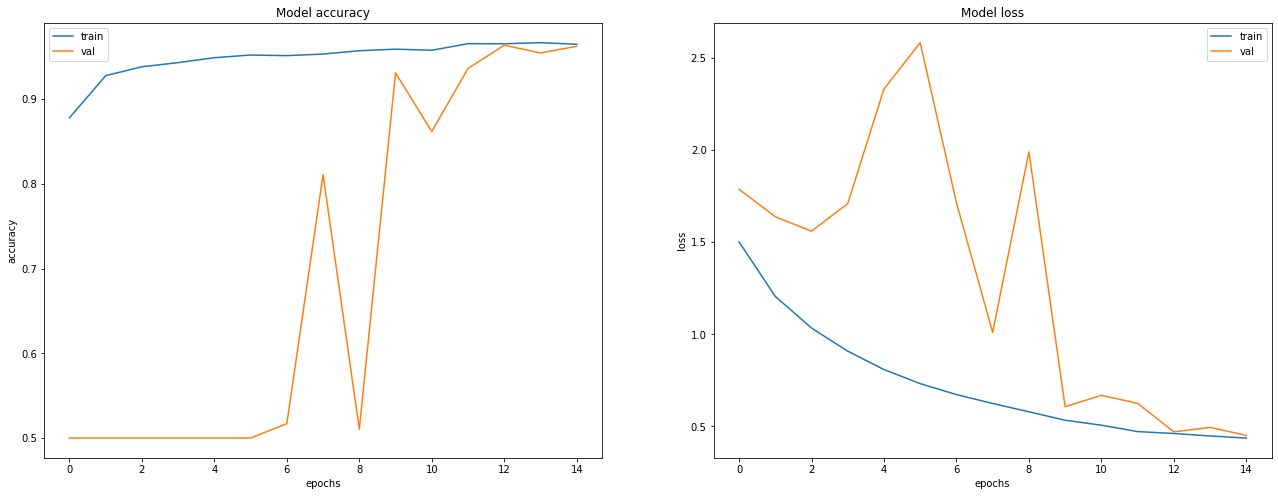

In [27]:
fig, ax = plt.subplots(1, 2, figsize=(22, 8))
ax = ax.ravel()

for i, met in enumerate(['accuracy', 'loss']):
    ax[i].plot(hist.history[met])
    ax[i].plot(hist.history['val_' + met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'val'])
plt.savefig('bad-acc-loss.jpeg')

In [ ]:
test_accuracy = model.evaluate(X_test, y_test)
print('The testing accuracy is :',test_accuracy[1]*100, '%')

In [ ]:
dkflk =

In [ ]:
* Conclusion: The testing accuracy is way lower compared to the training accuracy.Hence, the model is overfitting. More tuning needed. 

In [ ]:
#### Confusion Matrix

In [78]:
y_pred = model.predict_classes(X_test, batch_size=32)
#y_true = np.argmax(y_test_hat)
#y_test = np.argmax(y_test)
cm = confusion_matrix(y_test, y_pred > 0.9697008728981018)


In [79]:
cm

array([[178,  56],
       [ 12, 378]])

In [81]:
cm = confusion_matrix(y_test, y_pred > 0.5)
cm

array([[178,  56],
       [ 12, 378]])

In [31]:
y_pred_prob = model.predict(X_test, batch_size = 32)
cm = confusion_matrix(y_test, y_pred)

In [87]:
cm_prob = confusion_matrix(y_test, y_pred_prob > 0.524697)
cm_prob

array([[181,  53],
       [ 13, 377]])

In [ ]:
# Plotting
fig, ax = plt.subplots(figsize=(10, 6))
sns.heatmap(cm, annot=True, fmt = "g",cmap = "Blues",annot_kws={"size": 16})
sns.set(font_scale=1.2) # for label size
plt.xlabel('Predicted Value')
plt.ylabel('True Value')
ax.set_xticklabels(['Normal','Pneumonia'], fontsize = 12)
ax.set_yticklabels(['Normal','Pneumonia'], va='center', rotation = 90, position=(0,0.28),fontsize = 12)
plt.title('Confusion Matrix of Base Model' , fontsize = 16)
plt.savefig('graph/bad-confusion-matrix-base.png')

In [ ]:
#X_unused, X_test_new, y_unused , y_test_new = train_test_split(X_test, y_test, test_size = 0.99, random_state = 0, stratify =y_test, shuffle = True)

In [ ]:
#print(X_test_new.shape)
#print(y_test_new.shape)

In [ ]:
#y_pred_new = model.predict(X_test_new, batch_size=32)
#cm_new = confusion_matrix(y_test_new, y_pred_new > 0.5)
#cm_new

In [ ]:
#### Classfication Report

In [33]:
classification_rep = classification_report(y_test, y_pred)
classification_report
print(classification_rep)

              precision    recall  f1-score   support

           0       0.94      0.76      0.84       234
           1       0.87      0.97      0.92       390

    accuracy                           0.89       624
   macro avg       0.90      0.86      0.88       624
weighted avg       0.90      0.89      0.89       624



In [34]:
#### ROC Curve

In [35]:
y_pred_keras = model.predict_proba(X_test)
fpr, tpr, thres = roc_curve(y_test, y_pred_keras)

In [36]:
# Calculate gmeans
gmeans = np.sqrt(tpr * (1-fpr))
# Get the best threshold
ix = np.argmax(gmeans)
best_thres = thres[ix]
print('Best Threshold = {}'.format(best_thres))

Best Threshold = 0.9697008728981018


In [ ]:
plt.hist(y_pred_keras)

In [37]:
auc_keras = auc(fpr, tpr)

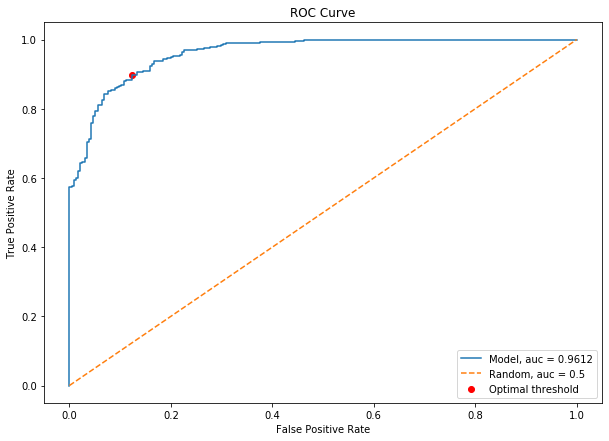

In [38]:
plt.subplots(figsize = (10,7))
plt.plot(fpr,tpr,label = model)
plt.plot([0,1], [0,1], linestyle='--', label='No Skill')
plt.scatter(fpr[ix], tpr[ix], marker = 'o', color = 'red', label = 'Best threshold')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(labels = ['Model, auc = {:.4f}'.format(auc_keras), 'Random, auc = 0.5', 'Optimal threshold'])
plt.savefig('graph/bad-roc.png')

In [ ]:
* Use y_pred_keras here instead of y_pred

In [66]:
y_test

array([1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0,
       1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1,
       0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1,
       1, 1, 0, 0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1, 1,
       1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1,
       1, 0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0,
       1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 0, 0,
       1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0,
       0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0,
       0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1,
       1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1,
       1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1,
       0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0,

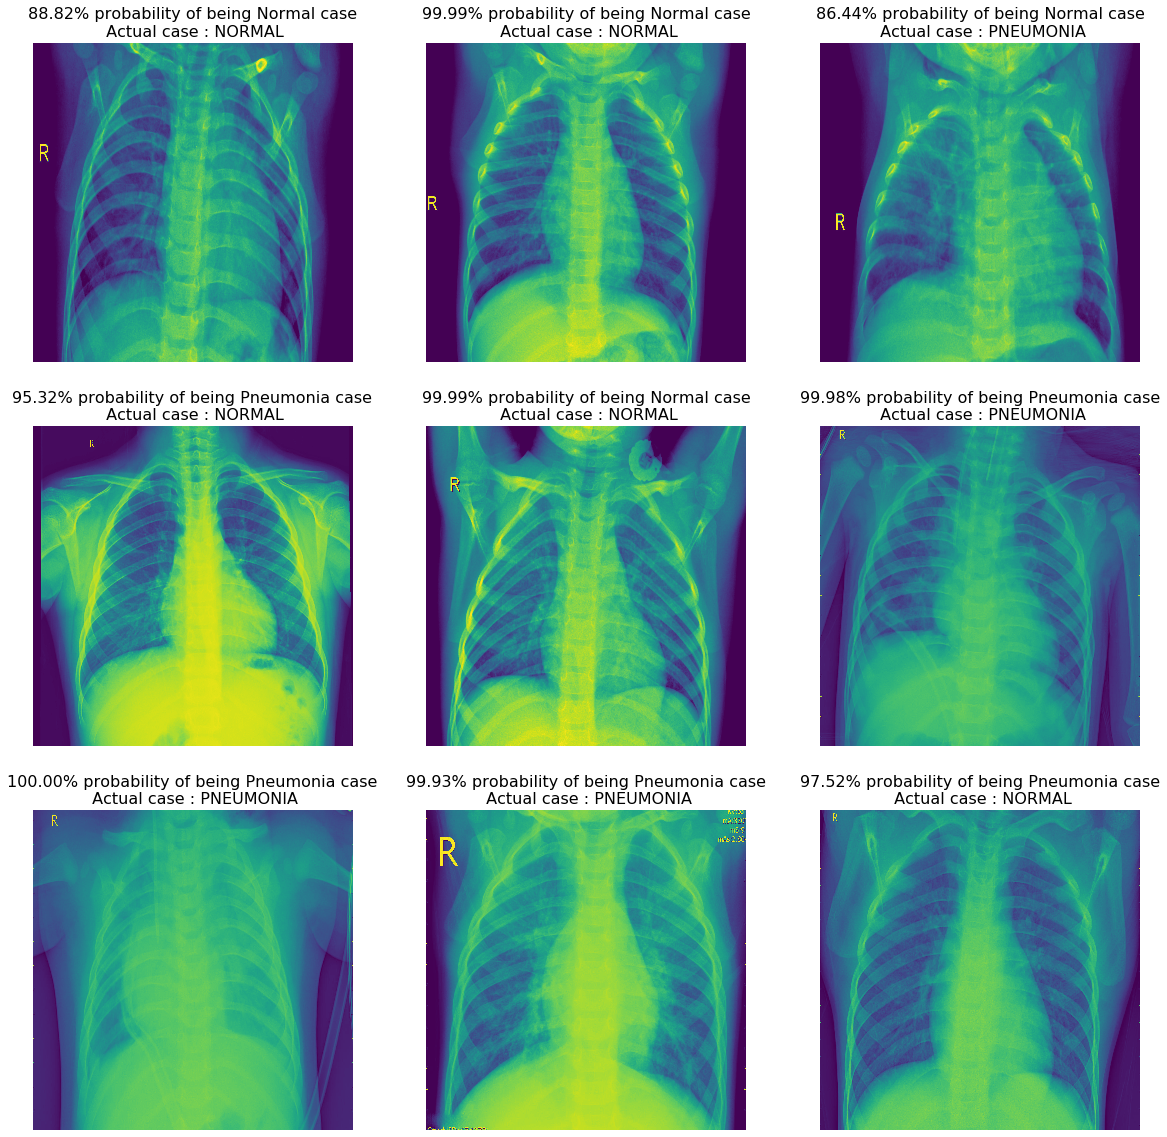

In [95]:
dic = {0:'NORMAL', 1:'PNEUMONIA'}
plt.figure(figsize=(20,20))
for i in range(0+25, 9+25):
  plt.subplot(3, 3, (i-25)+1)
  if y_pred[i] >= 0.5: 
      out = ('{:.2%} probability of being Pneumonia case'.format(y_pred_keras[i][0]))
         
  else: 
      out = ('{:.2%} probability of being Normal case'.format(1-y_pred_keras[i][0]))
      
      

  plt.title(out + "\n Actual case : "+ dic.get(y_test[i]), fontsize = 16)    
  plt.imshow(np.squeeze(X_test[i]))
  plt.axis('off')
plt.savefig('graph/pred-normal-base-model.jpeg')

In [69]:
from sklearn.metrics import precision_recall_curve

Best Threshold=0.524697, F-Score=0.921


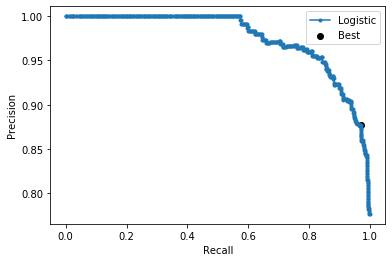

In [77]:
# Precision - Recall
# calculate roc curves
precision, recall, thresholds = precision_recall_curve(y_test, y_pred_keras)
# convert to f score
fscore = (2 * precision * recall) / (precision + recall)
# locate the index of the largest f score
ix = np.argmax(fscore)
print('Best Threshold=%f, F-Score=%.3f' % (thresholds[ix], fscore[ix]))
# plot the roc curve for the model
#no_skill = len(testy[testy==1]) / len(testy)
#pyplot.plot([0,1], [no_skill,no_skill], linestyle='--', label='No Skill')
plt.plot(recall, precision, marker='.', label='Logistic')
plt.scatter(recall[ix], precision[ix], marker='o', color='black', label='Best')
# axis labels
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.legend()
# show the plot
#pyplot.show()

In [ ]:
## Testing model with real life data

In [ ]:
pwd

In [ ]:
ls

In [ ]:
sample_path = 'sample-xray'

In [ ]:
from tensorflow.keras.preprocessing import image

In [ ]:
# preprocess sample imgage
covid_img = image.load_img(sample_path, color_mode = 'grayscale', target_size = (320,320))
covid_img = image.img_to_array(covid_img)
covid_img = covid_img/255
covid_img = np.expand_dims(covid_img, axis=0)

plt.imshow(np.squeeze(covid_img))

In [ ]:
covid_img.shape

In [ ]:
#predict 
covid_pred = model.predict(covid_img)

In [ ]:
plt.figure(figsize=(6,6))
plt.axis('off')
if covid_pred>= 0.5: 
    out = ('I am {:.2%} percent confirmed that this is a Pneumonia case'.format(covid_pred[0][0]))
    
else: 
    out = ('I am {:.2%} percent confirmed that this is a Normal case'.format(1-covid_pred[0][0]))
plt.title("Covid-19 Pneumonia X-ray \n"+out)  
plt.imshow(np.squeeze(covid_img))
plt.show()

In [ ]:
sample_path_ = 'covid-19-pneumonia-tube'
# preprocess sample imgage
covid_img_tube = image.load_img(sample_path_, color_mode = 'grayscale', target_size = (320,320))
covid_img_tube = image.img_to_array(covid_img_tube)
covid_img_tube = covid_img_tube/255
covid_img_tube = np.expand_dims(covid_img_tube, axis=0)

#plt.imshow(np.squeeze(covid_img_tube))

In [ ]:
#predict 
covid_pred_ = model.predict(covid_img_tube)

plt.figure(figsize=(6,6))
plt.axis('off')
if covid_pred>= 0.5: 
    out = ('I am {:.2%} percent confirmed that this is a Pneumonia case'.format(covid_pred_[0][0]))
    
else: 
    out = ('I am {:.2%} percent confirmed that this is a Normal case'.format(1-covid_pred_[0][0]))
plt.title("Covid-19 Pneumonia X-ray \n"+out)  
plt.imshow(np.squeeze(covid_img_tube))
plt.show()

## Grad Cam

In [ ]:
predict = model.predict(covid_img)
#print(decode_predictions(predict,top=3))
target_class = np.argmax(predict[0])
print("Target Class = %d"%target_class)

In [ ]:
=
last_conv = model.get_layer('block5_conv3')
grads = K.gradients(model.output[:,target_class],last_conv.output)[0]

In [ ]:
pooled_grads = K.mean(grads,axis=(0,1,2))
iterate = K.function([model.input],[pooled_grads,last_conv.output[0]])
pooled_grads_value,conv_layer_output = iterate([image_1])

In [ ]:

for i in range(512):
    conv_layer_output[:,:,i] *= pooled_grads_value[i]
heatmap = np.mean(conv_layer_output,axis=-1)

In [ ]:

for x in range(heatmap.shape[0]):
    for y in range(heatmap.shape[1]):
        heatmap[x,y] = np.max(heatmap[x,y],0)
view rawGradCamReLU hosted with ❤ by GitHub

In [ ]:
heatmap = np.maximum(heatmap,0)
heatmap /= np.max(heatmap)
plt.imshow(heatmap)

In [ ]:
upsample = resize(heatmap, (224,224),preserve_range=True)
plt.imshow(image)
plt.imshow(upsample,alpha=0.5)
plt.show()

In [ ]:
# VGG19

In [ ]:
snddkjbf =

In [ ]:
# data augmentation
train_datagen = ImageDataGenerator(rotation_range=40,
                                   rescale=1./255,
                                   shear_range=0.2,
                                   zoom_range=0.2,
                                   horizontal_flip=True,
                                   validation_split=0.1)

test_datagen = ImageDataGenerator(rescale=1./255)

In [ ]:
# define path
train = "data/chest_xray/train"
test = "data/chest_xray/test"
val = "data/chest_xray/val"

#load images and convert them into vector attributes

train_set = train_datagen.flow_from_directory(train,
                                         batch_size = 16, #1 #number of samples that will propagated thru the network to update the weights
                                         #shuffle = True, 
                                         class_mode = 'binary',
                                         target_size = (224,224),
                                         subset = 'training')
val = train_datagen.flow_from_directory(train,
                                         batch_size = 16,
                                         #shuffle = False,
                                         class_mode = 'binary',
                                         target_size = (224,224),
                                         subset = 'validation')
test_set = train_datagen.flow_from_directory(test,
                                         batch_size = 16,
                                         #shuffle = False,
                                         class_mode = 'binary',
                                         target_size = (224,224))


In [ ]:
vgg_model = VGG19(include_top=True, weights='imagenet')
vgg_model.summary()
# Pop off the last layer
vgg_model.layers.pop()

In [ ]:
predictions = Dense(1, activation='sigmoid')(vgg_model.layers[-1].output) # number of cells should be equal to number of class
vgg_model = Model(inputs=vgg_model.input, outputs=predictions)

vgg_model.compile(optimizer = Adam(lr=0.0001), loss='binary_crossentropy', metrics=['accuracy'])

In [ ]:
# Number of train and validation steps
train_steps=train_set.n//train_set.batch_size
validation_steps=val_set.n//val_set.batch_size

In [ ]:
filepath = "vgg19_weights.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_acc', save_best_only=True, verbose=1, mode='max')

In [ ]:
vgg_hist = vgg_model.fit_generator(train_set,
                    steps_per_epoch=train_steps,
                    validation_data=val_set,
                    validation_steps=validation_steps,
                    epochs=10,
                    callbacks = [checkpoint])

## Transfer Learning

In [ ]:
# pre-process & normalize image
def process_data_(img_path):
    img = cv2.imread(img_path)
    img = cv2.resize(img, (320, 320))
    #img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    #img = cv2.cvtColor(img,cv2.COLOR_GRAY2RGB)
    img = img/255.0
    img = np.reshape(img, (320, 320,-1))
    img = tf.convert_to_tensor(img[:,:,:3])

    
    return img

# write a function to split img and label into 2 separate numpy arrays
def compose_dataset_(df):
    img = []
    labels = []

    for img_path, label in df.values:
        img.append(process_data_(img_path))
        labels.append(label)
        
    return np.array(img), np.array(labels)

In [ ]:
X_train, y_train = compose_dataset_(train_df)
X_test, y_test = compose_dataset_(test_df)
X_val, y_val = compose_dataset_(val_df)

print('Train data shape: {}, Labels shape: {}'.format(X_train.shape, y_train.shape))
print('Test data shape: {}, Labels shape: {}'.format(X_test.shape, y_test.shape))
print('Validation data shape: {}, Labels shape: {}'.format(X_val.shape, y_val.shape))

In [ ]:
# define generator for traing data 
image_gen = ImageDataGenerator(
            #samplewise_center = True, #set each sample mean to 0 
            #samplewise_std_normalization = True, # divide each input by its std to normalize 
            #rescale = 1./255,
            rotation_range = 30, # randomly rotate image from -30 degree to 30 degree
            width_shift_range = 0.1, #randomly shift images horizontally
            height_shift_range = 0.1, #randomly shift images vertically
            shear_range = 0.1, #randomly change shear intensity
            zoom_range = 0.2, # random zoom images
            horizontal_flip = False, # randomly flip images
            vertical_flip = False
)

# fit generator on our train features
image_gen.fit(X_train)

In [ ]:
from keras.applications.densenet import DenseNet121

In [ ]:
dense = Sequential()

In [ ]:
dense = Sequential()
dense.add(DenseNet121(include_top = False, weights = 'imagenet', input_shape = (320, 320,3)))
#input_tensor = Input(shape=(224,224,1)
#dense.Conv2D(3,(3,3),padding='same')(input_tensor)
for layer in dense.layers:
        layer.trainable = False
dense.add(GlobalAveragePooling2D())
dense.add(Dense(128, activation = 'relu'))
dense.add(Dense(256, activation='relu'))
dense.add(BatchNormalization())
dense.add(Dropout(0.4))
    
dense.add(Dense(64, activation='relu'))
    
dense.add(BatchNormalization())
    
dense.add(Dropout(0.3))
    
dense.add(Dense(32, activation='relu'))
    
dense.add(BatchNormalization())
    
dense.add(Dropout(0.3))
dense.add(Dense(1, activation='sigmoid'))


#dense.add(Flatten())
#dense.add(Dense(1, activation = 'sigmoid'))
#dense.layers[0].trainable=False
dense.compile(Adam(0.001), loss='binary_crossentropy', metrics=['accuracy'])
dense.summary()

In [ ]:
batch_size = 32
steps_per_epoch = train_df.shape[0] // batch_size
validation_steps = val_df.shape[0] // batch_size
validation_steps

In [ ]:
# Callbacks
checkpoint = ModelCheckpoint(filepath='best_weights.hdf5', save_best_only=True, save_weights_only=True)
lr = ReduceLROnPlateau(monitor='val_loss', factor = 0.3, patience=5, verbose=2, mode='max')
early_stop = EarlyStopping(monitor='val_loss', min_delta = 0, patience = 2, mode='min')


In [ ]:
hist_2 = dense.fit_generator(image_gen.flow(X_train, y_train, batch_size = batch_size), #train set 
                 validation_data = (X_val, y_val), 
                 epochs = 15,
                 steps_per_epoch = steps_per_epoch,
                 verbose =1,
                 #class_weight= modified_weight_)
                 #validation_steps = 25
                 callbacks = [early_stop,lr])

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(22, 8))
ax = ax.ravel()

for i, met in enumerate(['accuracy', 'loss']):
    ax[i].plot(hist_2.history[met])
    ax[i].plot(hist_2.history['val_' + met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'val'])
plt.savefig('not-bad-acc-loss.jpeg')

In [ ]:
y_pred_ = dense.predict_classes(X_test, batch_size=32)

cm = confusion_matrix(y_test, y_pred_)

In [ ]:
cm

In [ ]:
dense.evaluate(X_test, y_test)